<a href="https://colab.research.google.com/github/DIDIHBABS/random_forest_models/blob/main/bank_marketing_classification/classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install ucimlrepo

In [2]:
pip install shap

In [4]:
pip install treeinterpreter

In [27]:
import pandas as pd
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn import metrics


from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import shap

from imblearn.over_sampling import SMOTE

import warnings

#Importing Dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
url= '/content/drive/MyDrive/Colab Notebooks/ML Engineering /Chapert 1 Example 3 Classification/bank.csv'
df = pd.read_csv(url, delimiter=';', decimal=',')


#Data preprocessing


In [10]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [41]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


#Checking Data Distribution

In [29]:
warnings.filterwarnings('ignore')

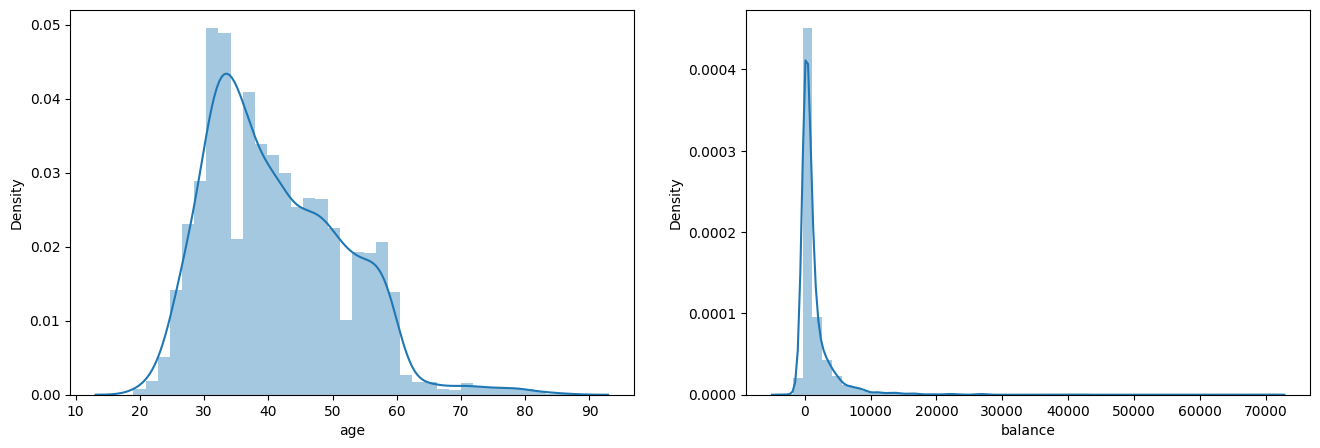

In [31]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df['age'])
plt.subplot(1,2,2)
sns.distplot(df['balance'])
plt.show()

#Checking for outliers

In [89]:
features = ['age', 'campaign', 'previous']

num_features = df[features].copy()

In [82]:
num_features.head()


,age,campaign,pdays,previous
0,30,1,-1,0
1,33,1,339,4
2,35,1,330,1
3,30,4,-1,0
4,59,1,-1,0


In [83]:
num_features.describe()

,age,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,2.793630,39.766645,0.542579
std,10.576211,3.109807,100.121124,1.693562
min,19.000000,1.000000,-1.000000,0.000000
25%,33.000000,1.000000,-1.000000,0.000000
50%,39.000000,2.000000,-1.000000,0.000000
75%,49.000000,3.000000,-1.000000,0.000000
max,87.000000,50.000000,871.000000,25.000000


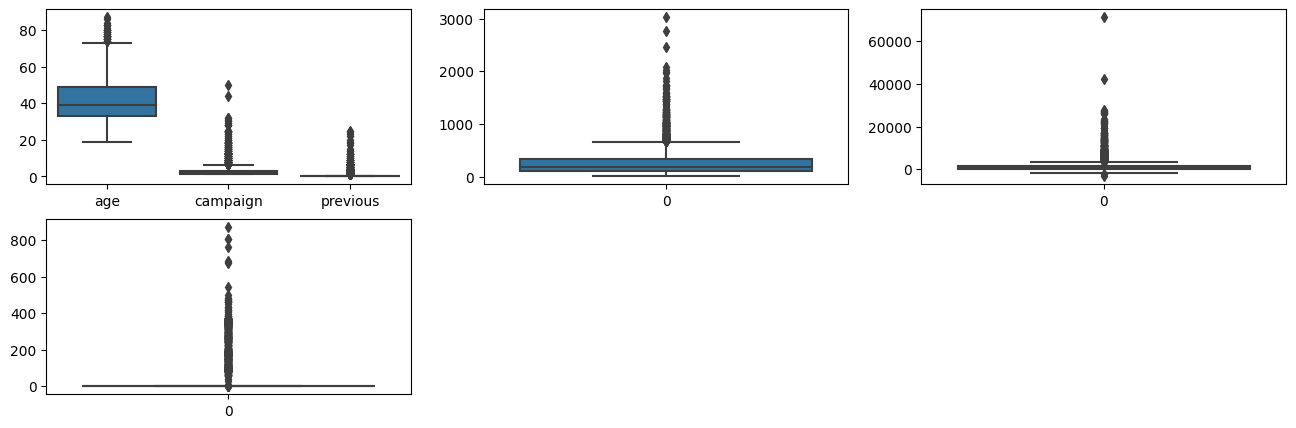

In [91]:
plt.figure(figsize=(16,5))
plt.subplot(2,3,1)
sns.boxplot(num_features)
plt.subplot(2,3,2)
sns.boxplot(df['duration'])
plt.subplot(2,3,3)
sns.boxplot(df['balance'])
plt.subplot(2,3,4)
sns.boxplot(df['pdays'])
plt.show()

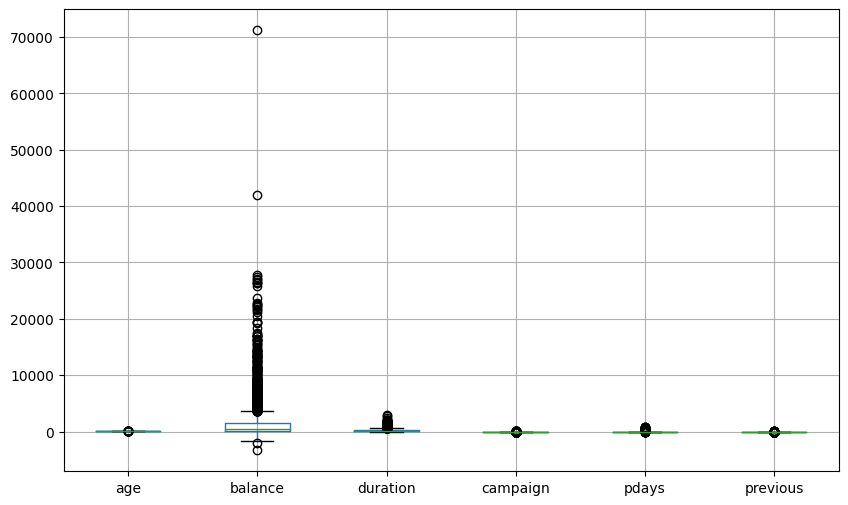

In [78]:
plt.figure(figsize=(10, 6))
num_features.boxplot()
plt.show()

In [63]:
outliers = []
def detect_outliers_iqr(data):
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data:
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers# Driver code
sample_outliers = detect_outliers_iqr(num_features['age'])
print("Outliers from IQR method: ", sample_outliers)


Outliers from IQR method:  [74, 74, 74, 75, 75, 75, 75, 75, 75, 76, 76, 77, 77, 77, 77, 77, 77, 78, 78, 78, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 81, 83, 83, 83, 83, 84, 86, 87]


In [64]:
outliers = []
def detect_outliers_zscore(data):
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code


In [66]:
sample_outliers = detect_outliers_zscore(num_features['balance'])

print("Outliers from Z-scores method: ", sample_outliers)

Outliers from Z-scores method:  [78, 77, 78, 75, 75, 77, 81, 83, 80, 77, 75, 80, 83, 75, 79, 77, 73, 86, 78, 77, 74, 73, 80, 73, 73, 74, 80, 80, 73, 75, 76, 79, 77, 87, 79, 76, 80, 79, 74, 75, 84, 83, 73, 83, 11971, 16873, 14093, 11494, 12186, 11219, 10924, 11262, 12607, 12437, 11269, 11555, 12519, 23663, 11084, 14752, 15311, 10786, 13669, 26965, 15030, 11303, 19358, 16353, 10758, 25824, 15459, 13494, 27733, 14533, 17555, 15520, 13711, 15834, 21244, 10788, 27359, 18347, 13044, 26306, 16430, 13342, 16992, 11386, 22370, 11417, 22856, 12223, 13658, 12531, 14220, 12569, 42045, 26394, 16957, 11797, 13229, 22171, 21664, 16264, 13204, 22546, 10787, 16874, 14363, 19317, 16178, 13893, 71188, 22196, 27069, 13683, 14440, 10655, 17361, 21515, 14412, 26452, 10907, 14058, 20453, 19447, 10888, 13156, 16063, 10910, 13117, 12877]


In [95]:
outliers = []
def detect_outliers_iqr(data):
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data:
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers# Driver code
sample_outliers = detect_outliers_iqr(df['duration'])
print("Outliers from IQR method: ", sample_outliers)

Outliers from IQR method:  [667, 668, 668, 669, 669, 670, 670, 670, 670, 671, 671, 672, 673, 674, 676, 676, 676, 676, 676, 679, 680, 681, 681, 682, 684, 686, 688, 688, 690, 691, 693, 696, 697, 697, 697, 698, 698, 699, 699, 700, 700, 700, 701, 701, 701, 702, 707, 709, 709, 712, 712, 712, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 725, 727, 727, 728, 730, 731, 731, 732, 732, 733, 735, 736, 736, 736, 738, 742, 743, 743, 744, 746, 747, 747, 748, 748, 749, 750, 753, 753, 754, 755, 755, 756, 756, 757, 757, 758, 759, 761, 761, 762, 763, 764, 765, 766, 766, 767, 767, 768, 768, 770, 770, 772, 773, 775, 777, 779, 780, 781, 783, 785, 788, 789, 792, 793, 796, 796, 798, 799, 799, 800, 803, 805, 806, 808, 808, 809, 812, 814, 815, 816, 816, 819, 819, 819, 820, 821, 825, 827, 830, 830, 834, 836, 836, 847, 854, 854, 857, 860, 860, 860, 863, 865, 866, 868, 869, 873, 875, 876, 877, 882, 882, 883, 883, 884, 891, 897, 897, 904, 904, 907, 908, 908, 910, 915, 916, 921, 923, 924, 929, 931, 935, 93

#Data Split

In [ ]:
X = df.drop('y', axis=1)
y = df['y'].apply(lambda x:1 if x == 'yes' else 0).copy()


In [ ]:
df_categorical = ["job", 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']
X = pd.get_dummies(X, drop_first=True, columns=df_categorical)

In [ ]:
X.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,79,1,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,33,4789,11,220,1,339,4,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,35,1350,16,185,1,330,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,1476,3,199,4,-1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,59,0,5,226,1,-1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Feature Selection


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("The accuracy of the Modesl is:\t", metrics.accuracy_score(rf_preds, y_test))

The accuracy of the Modesl is:	 0.8950276243093923


In [ ]:
print(classification_report(rf_preds, y_test))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       870
           1       0.19      0.54      0.29        35

    accuracy                           0.90       905
   macro avg       0.59      0.73      0.61       905
weighted avg       0.95      0.90      0.92       905



In [ ]:
explainer = shap.Explainer(rf)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

In [ ]:
explainer = shap.TreeExplainer(rf)

In [ ]:
X_train.loc[[421]]

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
421,37,502,7,551,1,351,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Calculate Shap values
choosen_instance = X_train.loc[[421]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
# Calculate Shap values
choosen_instance = X_train.loc[[300]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
# Calculate Shap values
choosen_instance = X_train.loc[[2]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

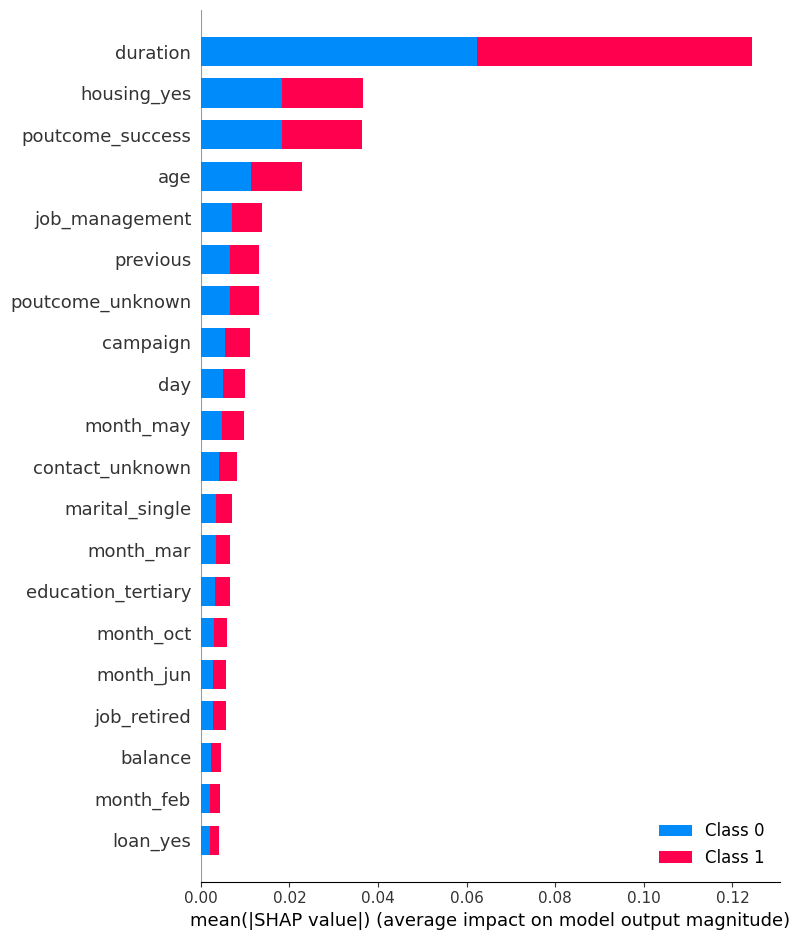

In [ ]:
shap.summary_plot(shap_values, X_test)

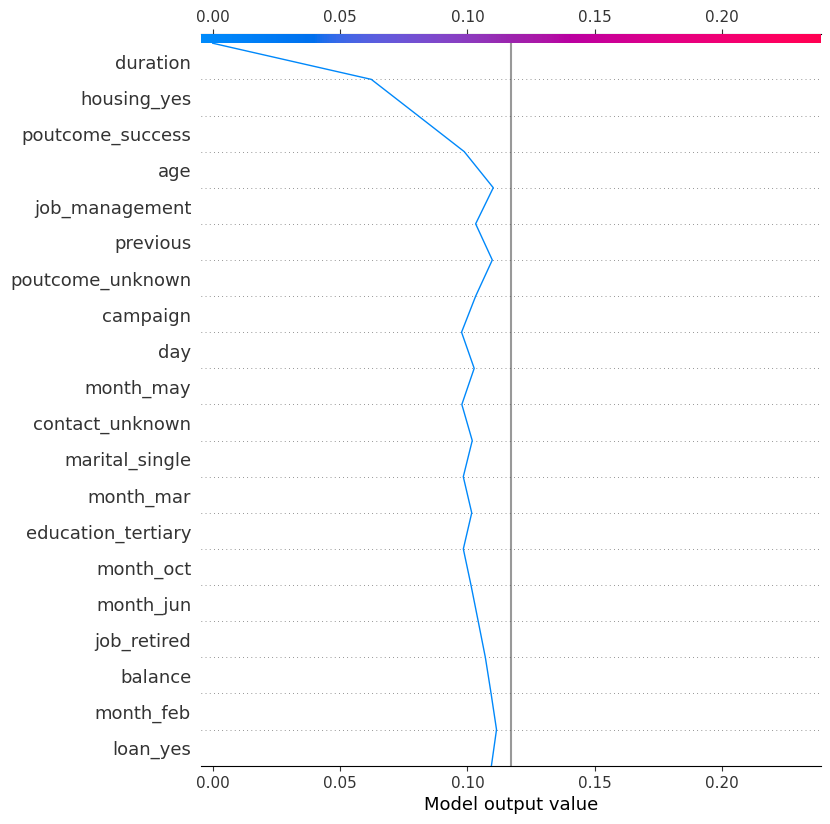

In [ ]:
shap.decision_plot(explainer.expected_value[1], shap_values[1], X_test.columns)

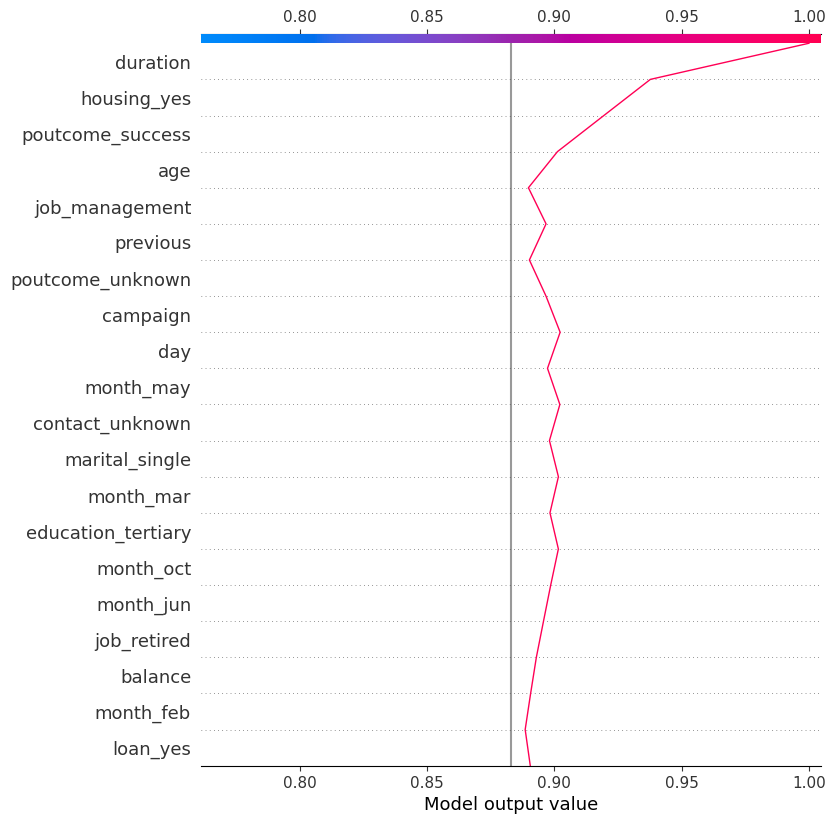

In [ ]:
shap.decision_plot(explainer.expected_value[0], shap_values[0], X_test.columns)

In [ ]:
pd.Series(np.mean(contributions, axis=0), index=X_train.columns).sort_values(ascending=True).plot.barh(color='green')

ValueError: ignored

In [ ]:
prediction, bias, contributions = ti.predict(rf, X_test)

pd.Series(contributions[0], index=X_test.columns).sort_values(ascending=True).plot.barh(color='green')

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

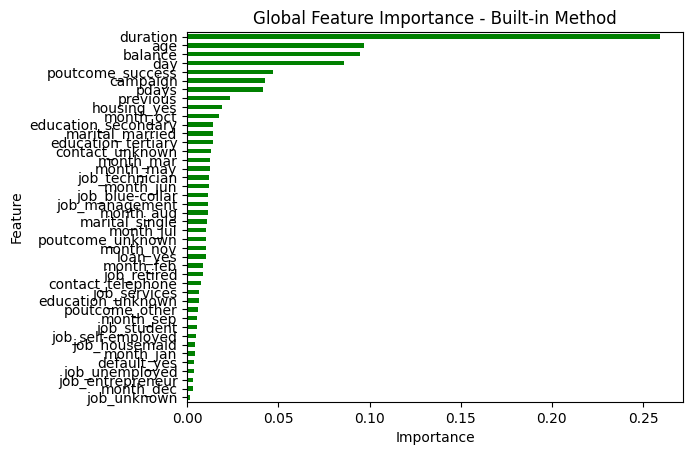

In [ ]:
global_importances = pd.Series(rf.feature_importances_,index=X_train.columns )
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

In [ ]:
X_train_random = X_train.copy()
X_train_random["RANDOM"] = np.random.RandomState(42).randn(X_train.shape[0])


rf_random = RandomForestClassifier(n_estimators=100, random_state=42)
rf_random.fit(X_train_random, y_train)



RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.inspection import permutation_importance

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

perm_importances = result.importances_mean
perm_std = result.importances_std
sorted_idx = perm_importances.argsort()
feature_names = X_test.columns



In [ ]:
pd.DataFrame({'Importance': perm_importances, 'Std': perm_std}, index=feature_names[sorted_idx]).sort_values('Importance',ascending=True)

,Importance,Std
month_oct,-5.082873e-03,0.002165
campaign,-3.646409e-03,0.001487
job_retired,-2.541436e-03,0.000994
month_aug,-2.099448e-03,0.000331
previous,-2.099448e-03,0.000773
job_housemaid,-1.988950e-03,0.002025
month_dec,-1.767956e-03,0.001013
job_services,-1.546961e-03,0.001127
pdays,-1.436464e-03,0.000994
contact_unknown,-1.215470e-03,0.001597


from matplotlib import pyplot as plt
_df_7['Importance'].plot(kind='hist', bins=20, title='Importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Std'].plot(kind='hist', bins=20, title='Std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='Importance', y='Std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Importance']
  ys = series['Std']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Importance', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Importance')
_ = plt.ylabel('Std')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Importance']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Importance'}, axis=1)
              .sort_values('Importance', ascending=True))
  xs = counted['Importance']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Importance', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Importance')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_12['Importance'].plot(kind='line', figsize=(8, 4), title='Importance')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Std'].plot(kind='line', figsize=(8, 4), title='Std')
plt.gca().spines[['top', 'right']].set_visible(False)

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

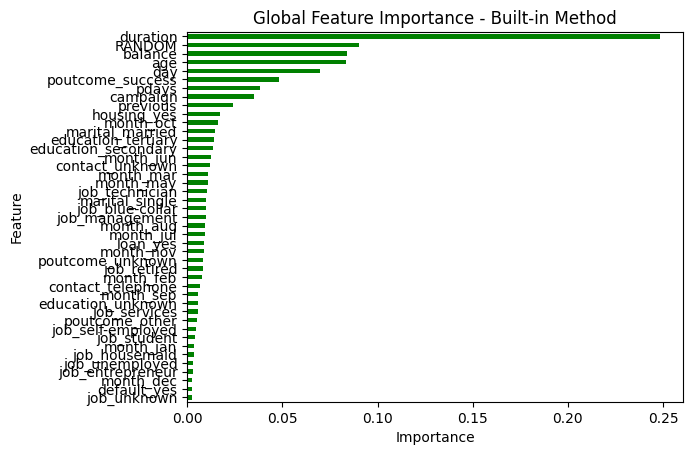

In [ ]:
global_importances_random = pd.Series(rf_random.feature_importances_, index=X_train_random.columns)
global_importances_random.sort_values(ascending=True, inplace=True)
global_importances_random.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

In [ ]:
import shap


#Hyperparameters Optimization RandomSearchC

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt','log2']
max_depth =[int(x) for x in np.linspace(10, 1000,10)]
min_samples_split = [2, 5, 10,14]
min_samples_leaf = [1, 2, 4,6,8]

In [ ]:
params = { 'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}

In [ ]:
rf = RandomForestClassifier()
rf_randomcv = RandomizedSearchCV(estimator=rf, param_distributions=params,
                        n_iter=100, cv=3,random_state=42, n_jobs=-1)
rf_randomcv.fit(X_train, y_train)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [ ]:
best_hyperparams = rf_randomcv.best_params_
best_hyperparams

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 890,
 'criterion': 'gini'}

In [ ]:
best_random_grid=rf_randomcv.best_estimator_

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = best_random_grid.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print("Accuracy Score : {}".format(accuracy_score(y_test,y_pred)))
print(classification_report(y_test,y_pred))


[[790  17]
 [ 74  24]]
Accuracy Score : 0.8994475138121547
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       807
           1       0.59      0.24      0.35        98

    accuracy                           0.90       905
   macro avg       0.75      0.61      0.65       905
weighted avg       0.88      0.90      0.88       905



#Hyperparameter optimization GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'criterion': [rf_randomcv.best_params_['criterion']],
    'max_depth': [rf_randomcv.best_params_['max_depth']],
    'max_features': [rf_randomcv.best_params_['max_features']],
    'min_samples_leaf': [rf_randomcv.best_params_['min_samples_leaf'],
                         rf_randomcv.best_params_['min_samples_leaf']+2,
                         rf_randomcv.best_params_['min_samples_leaf'] + 4],
    'min_samples_split': [rf_randomcv.best_params_['min_samples_split'] - 2,
                          rf_randomcv.best_params_['min_samples_split'] - 1,
                          rf_randomcv.best_params_['min_samples_split'],
                          rf_randomcv.best_params_['min_samples_split'] +1,
                          rf_randomcv.best_params_['min_samples_split'] + 2],
    'n_estimators': [rf_randomcv.best_params_['n_estimators'] - 200, rf_randomcv.best_params_['n_estimators'] - 100,
                     rf_randomcv.best_params_['n_estimators'],
                     rf_randomcv.best_params_['n_estimators'] + 100, rf_randomcv.best_params_['n_estimators'] + 200]
}


In [ ]:
rf_grid_search= GridSearchCV(estimator=rf, param_grid=param_grid,
                       cv=10, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

300 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [890],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [0, 1, 2, 3, 4],
                         'n_estimators': [1000, 1100, 1200, 1300, 1400]})

In [ ]:
best_grid = rf_grid_search.best_estimator_

In [ ]:
y_preds_grid = best_grid.predict(X_test)

print(confusion_matrix(y_test, y_preds_grid))
print("Accuracy Score {}".format(accuracy_score(y_test,y_preds_grid)))
print(classification_report(y_test,y_preds_grid))

#Improvement to the Model

-split to cross-validation
- Add the other feature and clean it
- Use grid search :Done
- check for the need for normalization or standardization
- read the data info for

TODO
- Check feature Importance
-Use feature Importance methods
Evaluate Model :Done
-interpret Evaluation
- Put them in production grade




In [ ]:
def ingest_and_prep_data(bank_dataset:str = '/content/drive/MyDrive/Colab Notebooks/ML Engineering /Chapert 1 Example 3 Classification/bank.csv') -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML Engineering /Chapert 1 Example 3 Classification/bank.csv', delimiter=';', decimal=',')

  feature_cols = ['job', 'marital', 'education', 'contact', 'housing', 'loan', 'default', 'day', 'duration', 'age']

  #Assigning variables

  X = df[feature_cols].copy()
  y = df['y'].apply(lambda x:1 if x == 'yes' else 0).copy()

  #Feature Engineering
  enc = OneHotEncoder(handle_unknown='ignore')
  X = enc.fit_transform(X)

  #Assigning variable
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  return X_train, X_test, y_train, y_test


In [ ]:
#Balancing the data
def rebalance_classes(X: pd.DataFrame, y: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    sm = SMOTE()
    X_balanced, y_balanced = sm.fit_resample(X, y)
    return X_balanced, y_balanced

In [ ]:
def get_hyperparam_grid() -> dict:
    # Hyperparameter optimisation
    n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]  # Create the random grid


    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    return random_grid

In [ ]:
def get_randomised_rf_cv(random_grid: dict) -> sklearn.model_selection._search.RandomizedSearchCV:
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation,
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(
        estimator=rf,
        param_distributions=random_grid,
        n_iter=100,
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1,
        scoring='f1'
    )
    return rf_random


In [ ]:
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = ingest_and_prep_data()

    X_balanced, y_balanced = rebalance_classes(X_train, y_train)

    rf_random = get_randomised_rf_cv(
        random_grid=get_hyperparam_grid()
        )

    rf_random.fit(X_balanced, y_balanced)

In [ ]:
print("Best Hyperparameters are:", rf_random.best_params)
print("Best score is :", rf_random.best_score)

In [ ]:
def evaluation():
  X_train, X_test, y_train, y_test = ingest_and_prep_data()
  y_pred = rf.predict(X_test)

  conf_matrix = confusion_matrix(y_test, y_pred)
  acc_rf = accuracy_score(y_test, y_pred)

  cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels = [False, True])

  cm_display.plot()
  cm_plt = plt.show()
  accuracy = print("Accuracy :" ,accuracy_score(y_test, y_pred))
  summary = print(classification_report(y_test, y_pred))
  F1 = print("F1_score :" ,f1_score(y_test, y_pred))
  return cm_plt, accuracy , summary

In [ ]:
get_hyperparam_grid()


In [ ]:
def grid_search_hyperparams()->dict:
  n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
    # Number of features to consider at every split
  max_features = ['auto', 'sqrt']
  min_samples_leaf =[1, 2, 4]
  min_samples_split =[2, 5, 10]


  grid_space ={'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split

  }
  return grid_space

In [ ]:
def get_grid_search(grid_space: dict) -> sklearn.model_selection._search.GridSearchCV:
  rf = RandomForestClassifier()

  grid = GridSearchCV(rf, param_grid=grid_search_hyperparams(),
                      scoring='accuracy')
  return grid


In [ ]:
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = ingest_and_prep_data()

    X_balanced, y_balanced = rebalance_classes(X_train, y_train)

    grid = get_grid_search(
        grid_space=grid_search_hyperparams()
        )

    grid.fit(X_balanced, y_balanced)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

In [ ]:
print("Best Hyperparameters are:", grid.best_params)
print("Best score is :", grid.best_score)

In [ ]:
def rf_model():
  clf = RandomForestClassifier(
      n_estimators=50,
      criterion='gini',
      max_depth=5,
      min_samples_split=2,
      min_samples_leaf=1,
      min_weight_fraction_leaf=0.0,
      max_features = None,
      max_leaf_nodes=None,
      bootstrap=True,
      oob_score=False,
      n_jobs=-1,
      random_state=0,
      verbose=0,
      warm_start=False,
      class_weight='balanced'
  )
  return clf



In [ ]:


def evaluation():
  X_train, X_test, y_train, y_test = ingest_and_prep_data()
  y_pred = rf_random.predict(X_test)

  conf_matrix = confusion_matrix(y_test, y_pred)
  acc_rf = accuracy_score(y_test, y_pred)

  cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels = [False, True])

  cm_display.plot()
  cm_plt = plt.show()
  accuracy = print("Accuracy :" ,accuracy_score(y_test, y_pred))
  summary = print(classification_report(y_test, y_pred))
  F1 = print("F1_score :" ,f1_score(y_test, y_pred))
  return cm_plt, accuracy , summary



